In [5]:
import difflib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.spatial import distance_matrix
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
import warnings

warnings.simplefilter("ignore", pd.errors.SettingWithCopyError)
pd.set_option('display.max_columns', None)

# Rainfall

In [6]:
df_rainfall = pd.read_csv("../datasets/checkpoints/rainfall.csv")

display(df_rainfall.info())
display(df_rainfall.describe())
display(df_rainfall)
df_rainfall.isna().mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80651784 entries, 0 to 80651783
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Hour           int64  
 1   Precipitation  float64
 2   Date           object 
 3   Lat            float64
 4   Long           float64
dtypes: float64(3), int64(1), object(1)
memory usage: 3.0+ GB


None

,Hour,Precipitation,Lat,Long
count,8.065178e+07,8.061156e+07,8.065178e+07,8.065178e+07
mean,1.150000e+01,2.602369e-01,5.569723e+00,-7.461878e+01
std,6.922187e+00,1.107324e+00,2.569344e+00,1.690394e+00
min,0.000000e+00,0.000000e+00,-4.203165e+00,-8.171853e+01
25%,5.750000e+00,0.000000e+00,4.263082e+00,-7.574878e+01
50%,1.150000e+01,0.000000e+00,5.516347e+00,-7.474094e+01
75%,1.725000e+01,2.000000e-01,6.849736e+00,-7.342148e+01
max,2.300000e+01,2.935000e+02,1.338142e+01,-6.704646e+01


,Hour,Precipitation,Date,Lat,Long
0,0,0.1,2010-01-01,-1.747145,-73.209101
1,1,0.1,2010-01-01,-1.747145,-73.209101
2,2,0.1,2010-01-01,-1.747145,-73.209101
3,3,0.1,2010-01-01,-1.747145,-73.209101
4,4,0.1,2010-01-01,-1.747145,-73.209101
...,...,...,...,...,...
80651779,19,NaN,2018-12-31,2.892506,-72.133175
80651780,20,0.0,2018-12-31,2.892506,-72.133175
80651781,21,0.0,2018-12-31,2.892506,-72.133175
80651782,22,0.0,2018-12-31,2.892506,-72.133175


Hour             0.000000
Precipitation    0.000499
Date             0.000000
Lat              0.000000
Long             0.000000
dtype: float64

In [7]:
df_rainfall["Precipitation"] = df_rainfall["Precipitation"].fillna(0)

df_rainfall["Precipitation"].describe()

count    8.065178e+07
mean     2.601072e-01
std      1.107063e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e-01
max      2.935000e+02
Name: Precipitation, dtype: float64

In [8]:
df_rainfall_total = (
    df_rainfall
        .groupby(["Date", "Lat", "Long"])["Precipitation"]
        .sum()
        .reset_index(name = "Total Rainfall Today")
)
df_rainfall_duration = (
    df_rainfall
        .groupby(["Date", "Lat", "Long"])["Precipitation"]
        .apply(lambda x: (x > 0).sum())
        .reset_index(name = "Rainfall Duration Today")
)
df_rainfall2 = pd.merge(
    df_rainfall_total,
    df_rainfall_duration,
    on = ["Date", "Lat", "Long"]
)

display(df_rainfall2.info())
display(df_rainfall2.describe())
display(df_rainfall2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360491 entries, 0 to 3360490
Data columns (total 5 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Date                     object 
 1   Lat                      float64
 2   Long                     float64
 3   Total Rainfall Today     float64
 4   Rainfall Duration Today  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 128.2+ MB


None

,Lat,Long,Total Rainfall Today,Rainfall Duration Today
count,3.360491e+06,3.360491e+06,3.360491e+06,3.360491e+06
mean,5.569723e+00,-7.461878e+01,6.242572e+00,1.044415e+01
std,2.569344e+00,1.690394e+00,1.000245e+01,8.417210e+00
min,-4.203165e+00,-8.171853e+01,0.000000e+00,0.000000e+00
25%,4.263082e+00,-7.574878e+01,4.000000e-01,2.000000e+00
50%,5.516347e+00,-7.474094e+01,2.800000e+00,1.000000e+01
75%,6.849736e+00,-7.342148e+01,8.300000e+00,1.700000e+01
max,1.338142e+01,-6.704646e+01,3.723000e+02,2.400000e+01


,Date,Lat,Long,Total Rainfall Today,Rainfall Duration Today
0,2010-01-01,-4.203165,-69.935907,0.4,4
1,2010-01-01,-3.788867,-70.355642,0.5,5
2,2010-01-01,-2.458989,-69.859741,0.3,3
3,2010-01-01,-1.747145,-73.209101,0.5,5
4,2010-01-01,-1.378972,-72.804280,0.0,0
...,...,...,...,...,...
3360486,2018-12-31,11.240355,-74.211023,0.0,0
3360487,2018-12-31,11.380054,-72.242246,0.0,0
3360488,2018-12-31,11.538415,-72.916784,0.0,0
3360489,2018-12-31,11.576376,-72.567804,0.0,0


In [9]:
df_rainfall = df_rainfall2.copy()

del df_rainfall_total
del df_rainfall_duration
del df_rainfall2

# Forest Data

In [10]:
df_forest = pd.read_csv("../datasets/checkpoints/forest_loss.csv")

df_forest.rename(
    {
        "subnational1": "Department",
        "subnational2": "Municipality"
    },
    axis = 1,
    inplace = True
)

display(df_forest.info())
display(df_forest.describe())
df_forest

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187440 entries, 0 to 187439
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   country            187440 non-null  object 
 1   Department         187440 non-null  object 
 2   Municipality       187440 non-null  object 
 3   Lat                187440 non-null  float64
 4   Long               187440 non-null  float64
 5   elevation          187440 non-null  float64
 6   threshold          187440 non-null  int64  
 7   Year               187440 non-null  int64  
 8   gain_2000-2020_ha  187440 non-null  int64  
 9   extent_2010_ha     187440 non-null  int64  
 10  area_ha            187440 non-null  int64  
 11  extent_2000_ha     187440 non-null  int64  
 12  forest_loss_ha     187440 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 18.6+ MB


None

,Lat,Long,elevation,threshold,Year,gain_2000-2020_ha,extent_2010_ha,area_ha,extent_2000_ha,forest_loss_ha
count,187440.000000,187440.000000,187440.000000,187440.000000,187440.000000,187440.000000,1.874400e+05,1.874400e+05,1.874400e+05,187440.000000
mean,5.550268,-74.630470,1189.064659,28.125000,2011.500000,1018.963380,7.952658e+04,1.067379e+05,7.975576e+04,220.545657
std,2.571924,1.703351,932.783699,22.491378,6.344306,2570.691511,2.758679e+05,3.104969e+05,2.770098e+05,1007.345449
min,-4.203165,-81.718525,0.000000,0.000000,2001.000000,0.000000,0.000000e+00,9.300000e+01,0.000000e+00,0.000000
25%,4.216550,-75.761865,223.823059,13.750000,2006.000000,75.000000,6.935750e+03,1.362200e+04,6.929750e+03,7.000000
50%,5.503838,-74.755201,1191.455566,22.500000,2011.500000,209.000000,1.757350e+04,2.882300e+04,1.744900e+04,31.000000
75%,6.854309,-73.418021,1909.895264,35.000000,2017.000000,653.000000,4.524025e+04,7.152900e+04,4.536350e+04,123.000000
max,13.381425,-67.046459,3670.898682,75.000000,2022.000000,38765.000000,4.967616e+06,4.967616e+06,4.967616e+06,31826.000000


,country,Department,Municipality,Lat,Long,elevation,threshold,Year,gain_2000-2020_ha,extent_2010_ha,area_ha,extent_2000_ha,forest_loss_ha
0,Colombia,Amazonas,El Encanto,-1.747145,-73.209101,120.301346,0,2001,773,1027642,1027642,1027642,212
1,Colombia,Amazonas,El Encanto,-1.747145,-73.209101,120.301346,0,2002,773,1027642,1027642,1027642,182
2,Colombia,Amazonas,El Encanto,-1.747145,-73.209101,120.301346,0,2003,773,1027642,1027642,1027642,88
3,Colombia,Amazonas,El Encanto,-1.747145,-73.209101,120.301346,0,2004,773,1027642,1027642,1027642,169
4,Colombia,Amazonas,El Encanto,-1.747145,-73.209101,120.301346,0,2005,773,1027642,1027642,1027642,147
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187435,Colombia,Vichada,Santa Rosalía,5.135381,-70.864961,116.421806,75,2018,6493,28283,432087,30129,23
187436,Colombia,Vichada,Santa Rosalía,5.135381,-70.864961,116.421806,75,2019,6493,28283,432087,30129,24
187437,Colombia,Vichada,Santa Rosalía,5.135381,-70.864961,116.421806,75,2020,6493,28283,432087,30129,38
187438,Colombia,Vichada,Santa Rosalía,5.135381,-70.864961,116.421806,75,2021,6493,28283,432087,30129,67


In [11]:
df_forest = df_forest.loc[
    (df_forest["threshold"] == 30) &
    (df_forest["Year"] >= 2010)
].reset_index(drop = True)

df_forest["cum_forest_loss"] = df_forest.groupby(["Department", "Municipality"])["forest_loss_ha"].cumsum()
df_forest["Forest Loss %"] = (df_forest["cum_forest_loss"] / df_forest["extent_2010_ha"]).fillna(0)

df_forest = df_forest[[
    "Department", "Municipality", "Lat", "Long", "elevation", "Year", "Forest Loss %"
]]

df_forest

,Department,Municipality,Lat,Long,elevation,Year,Forest Loss %
0,Amazonas,El Encanto,-1.747145,-73.209101,120.301346,2010,0.000339
1,Amazonas,El Encanto,-1.747145,-73.209101,120.301346,2011,0.000531
2,Amazonas,El Encanto,-1.747145,-73.209101,120.301346,2012,0.000729
3,Amazonas,El Encanto,-1.747145,-73.209101,120.301346,2013,0.000872
4,Amazonas,El Encanto,-1.747145,-73.209101,120.301346,2014,0.001111
...,...,...,...,...,...,...,...
13840,Vichada,Santa Rosalía,5.135381,-70.864961,116.421806,2018,0.005562
13841,Vichada,Santa Rosalía,5.135381,-70.864961,116.421806,2019,0.006177
13842,Vichada,Santa Rosalía,5.135381,-70.864961,116.421806,2020,0.007157
13843,Vichada,Santa Rosalía,5.135381,-70.864961,116.421806,2021,0.008935


# Landslides

In [12]:
df_landslides = pd.read_excel("../datasets/original/desinventar_landslides.xls")

display(df_landslides.info())
display(df_landslides.describe())
df_landslides

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10438 entries, 0 to 10437
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Serial                10438 non-null  object 
 1   Event                 10438 non-null  object 
 2   Date (YMD)            10438 non-null  object 
 3   Comments              7908 non-null   object 
 4   Cause                 10438 non-null  object 
 5   Description of Cause  1028 non-null   object 
 6   Source                10438 non-null  object 
 7   Magnitude             71 non-null     object 
 8   GLIDEnumber           0 non-null      float64
 9   Other sectors         1182 non-null   object 
 10  DataCards             10438 non-null  int64  
 11  Deaths                1556 non-null   float64
 12  Injured               881 non-null    float64
 13  Missing               166 non-null    float64
 14  Houses Destroyed      2249 non-null   float64
 15  Houses Damaged     

None

,GLIDEnumber,DataCards,Deaths,Injured,Missing,Houses Destroyed,Houses Damaged,Directly affected,Indirectly Affected,Relocated,Evacuated,Losses $USD,Losses $Local,Education centers,Hospitals,Damages in crops Ha.,Lost Cattle,Damages in roads Mts,Duration (d),fichas.latitude,fichas.longitude
count,0.0,10438.0,1556.000000,881.000000,166.000000,2249.000000,2615.000000,488.000000,3839.000000,11.000000,178.000000,4.000000e+00,2.050000e+02,291.000000,37.000000,237.000000,5.000000,747.000000,70.000000,0.0,0.0
mean,NaN,1.0,4.699871,4.396141,5.138554,10.668742,38.911663,139.747951,710.613701,282.727273,241.898876,4.100000e+06,1.964098e+08,2.134021,1.243243,1080.534346,30.200000,722.641232,8.128571,NaN,NaN
std,NaN,0.0,16.654014,8.539530,11.957453,39.050600,120.455401,575.937507,10786.405284,737.457265,630.320671,4.793050e+06,2.106452e+09,3.465979,1.038305,4676.609490,23.477649,6982.412451,19.241351,NaN,NaN
min,NaN,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,5.000000e-01,2.000000e+01,1.000000,1.000000,0.020000,9.000000,1.000000,2.000000,NaN,NaN
25%,NaN,1.0,1.000000,1.000000,1.000000,1.000000,2.000000,6.000000,10.000000,16.000000,24.000000,3.000001e+05,6.850000e+05,1.000000,1.000000,20.000000,10.000000,1.000000,2.000000,NaN,NaN
50%,NaN,1.0,2.000000,2.000000,2.000000,2.000000,8.000000,25.000000,45.000000,65.000000,53.000000,3.200000e+06,3.839900e+06,1.000000,1.000000,80.000000,22.000000,1.000000,4.000000,NaN,NaN
75%,NaN,1.0,4.000000,4.000000,4.000000,7.000000,30.000000,75.000000,200.000000,119.000000,203.750000,7.000000e+06,1.000000e+07,2.000000,1.000000,311.000000,50.000000,5.000000,6.000000,NaN,NaN
max,NaN,1.0,500.000000,150.000000,100.000000,949.000000,2635.000000,8985.000000,400000.000000,2500.000000,5000.000000,1.000000e+07,3.000000e+10,50.000000,7.000000,40708.000000,60.000000,160000.000000,150.000000,NaN,NaN


,Serial,Event,Date (YMD),Comments,Cause,Description of Cause,Source,Magnitude,GLIDEnumber,Other sectors,DataCards,Deaths,Injured,Missing,Houses Destroyed,Houses Damaged,Directly affected,Indirectly Affected,Relocated,Evacuated,Losses $USD,Losses $Local,Education centers,Hospitals,Damages in crops Ha.,Lost Cattle,Damages in roads Mts,Duration (d),fichas.latitude,fichas.longitude,Departamento,Municipio
0,UNGRD-2016-0344,LANDSLIDE,2016/12/31,MUNICIPIO IQUIRA INFORMACIÓN PRELIMINAR EMERGE...,UNKNOWN,NaN,UNGRD,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Huila,Iquira
1,UNGRD-2016-0344,LANDSLIDE,2016/12/30,DCC INFORMA QUE EN EL MUNICIPIO MOCOA VÍA MOCO...,UNKNOWN,NaN,UNGRD,NaN,NaN,3 Vehículos,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Putumayo,Mocoa
2,UNGRD-2016-0343,LANDSLIDE,2016/12/28,CDGRD DE ANTIOQUIA; INFORMA; MUNICIPIO DE CO...,UNKNOWN,NaN,UNGRD,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,262.0,NaN,262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Antioquia,Copacabana
3,UNGRD-2016-0343,LANDSLIDE,2016/12/27,CDGRD DEL CAUCA; REPORTA; MUNICIPIO DE TIBIO; ...,UNKNOWN,NaN,UNGRD,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cauca,Timbío
4,UNGRD-2016-0343,LANDSLIDE,2016/12/25,CDGRD DE CUNDINAMARCA; INFORMA; CARLOS MARIO C...,RAIN,NaN,UNGRD,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,13.0,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cundinamarca,Pandi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10433,1984-0470,LANDSLIDE,1984/10/25,En la intendencia del Putumayo en el sitio El...,RAIN,NaN,EL TIEMPO 1984-10-26,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Putumayo,Mocoa
10434,1984-0469,LANDSLIDE,1984/10/25,Sobre la carretera al mar el Distrito de Carr...,RAIN,NaN,EL TIEMPO 1984-10-26,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nariño,Ricaurte
10435,1984-0468,LANDSLIDE,1984/10/25,En la vía que de Pasto conduce al aeropuerto A...,RAIN,NaN,EL TIEMPO 1984-10-26,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nariño,Pasto
10436,1984-0467,LANDSLIDE,1984/10/25,Sobre la carretera al mar el Distrito de Carr...,RAIN,NaN,EL TIEMPO 1984-10-26,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nariño,Barbacoas


In [13]:
df_landslides["Date (YMD)"] = pd.to_datetime(df_landslides["Date (YMD)"], format = "%Y/%m/%d", errors = "coerce")
df_landslides["Year"] = df_landslides["Date (YMD)"].dt.year
df_landslides = df_landslides[df_landslides["Year"] >= 2010].sort_values("Date (YMD)")
df_landslides = df_landslides[["Date (YMD)", "Departamento", "Municipio", "Year"]].dropna().reset_index(drop = True)

display(df_landslides.info())
df_landslides["Year"].value_counts(sort = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3737 entries, 0 to 3736
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date (YMD)    3737 non-null   datetime64[ns]
 1   Departamento  3737 non-null   object        
 2   Municipio     3737 non-null   object        
 3   Year          3737 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 116.9+ KB


None

Year
2010.0    518
2011.0    873
2012.0    528
2013.0    421
2014.0    359
2015.0    225
2016.0    338
2017.0    475
Name: count, dtype: int64

In [14]:
departments = df_forest["Department"].unique()
municipalities = df_forest["Municipality"].unique()
departments.sort()
municipalities.sort()

dept_munic = {}
for dept in departments:
    df_tmp = df_forest[df_forest["Department"] == dept]
    dept_munic[dept] = df_tmp["Municipality"].unique()

In [15]:
pd.set_option('display.max_rows', None)

replacements = [
    ("Antioquia", "La Pintada", "Antioquia", "Abejorral"),
    ("Antioquia", "La Unión", "Antioquia", "La Unión de Sucre"),
    ("Bogotá D.C.", "Bogota", "Cundinamarca", "Santafé de Bogotá"),
    ("Bolívar", "Cartagena", "Bolívar", "Cartagena de Indias"),
    ("Caldas",	"Norcasia", "Caldas", "Samaná"),
    ("Cauca", "López", "Cauca", "López de Micay"),
    ("Cauca", "Piamonte", "Cauca", "Santa Rosa"),
    ("Cauca", "Villa Rica", "Cauca", "Buenos Aires"),
    ("Cesar", "Pueblo Bello", "Cesar", "Valledupar"),
    ("Chocó", "Atrato", "Chocó", "El Carmen de Atrato"),
    ("Chocó", "Medio Atrato", "Chocó", "Nuquí"),
    ("Chocó", "Medio Baudo", "Chocó", "Bajo Baudó"),
    ("Chocó", "Medio San Juan", "Chocó", "Quibdó"),
    ("Cundinamarca", "El Rosal", "Cundinamarca", "Facatativá"),
    ("La Guajira", "Albania", "La Guajira", "Barrancas"),
    ("Nariño", "El Peñol", "Nariño", "Los Andes"),
    ("Nariño", "Nariño", "Nariño", "La Florida"),
    ("Nariño", "Pasto", "Nariño", "San Juan de Pasto"),
    ("Norte de Santander", "Cúcuta", "Norte de Santander", "San José de Cúcuta"),
    ("Norte de Santander", "Salazar", "Norte de Santander", "Salazar de las Palmas"),
    ("Norte de Santander", "Silos", "Norte de Santander", "Santo Domingo de Silos"),
    ("Putumayo", "Mocoa", "Putumayo", "San Miguel de Mocoa"),
    ("Tolima", "Palocabildo", "Tolima", "Fresno"),
    ("Valle del Cauca", "Cali", "Valle del Cauca", "Calima")
]

df_landslides2 = df_landslides.copy()
for i, row in df_landslides.iterrows():
    dept = row["Departamento"]
    munic = row["Municipio"]
    
    found = False
    for replacement in replacements:
        if dept == replacement[0] and munic== replacement[1]:
            df_landslides2.at[i, "Departamento"] = replacement[2]
            df_landslides2.at[i, "Municipio"] = replacement[3]
            found = True
            break
        
    if not found:
        if dept not in departments:
            results = difflib.get_close_matches(dept, departments)
            if len(results) > 0 and dept_munic and munic in dept_munic[results[0]]:
                df_landslides2.at[i, "Departamento"] = results[0]
        elif munic not in dept_munic[dept]:
            results = difflib.get_close_matches(munic, dept_munic[dept])
            if len(results) > 0:
                df_landslides2.at[i, "Municipio"] = results[0]
            else:
                df_landslides2.at[i, "Municipio"] = "{}_".format(munic)
            
df_missing = df_landslides2.loc[
    (~df_landslides2["Municipio"].isin(municipalities)) |
    (~df_landslides2["Departamento"].isin(departments))
][["Departamento", "Municipio"]].drop_duplicates()
print(len(df_missing))
display(df_missing.sort_values(["Departamento", "Municipio"]))

pd.set_option('display.max_rows', 10)

0


,Departamento,Municipio


In [16]:
df_landslides = (
    df_landslides2
        .copy()
        .rename({ 
            "Date (YMD)": "Date",
            "Departamento": "Department",
            "Municipio": "Municipality"
        }, axis = 1)
        .drop("Year", axis = 1)
)
df_landslides["Landslide"] = 1

del df_landslides2
df_landslides

,Date,Department,Municipality,Landslide
0,2010-01-10,Cundinamarca,Santafé de Bogotá,1
1,2010-02-09,Boyacá,San Mateo,1
2,2010-02-11,Valle del Cauca,Buenaventura,1
3,2010-03-11,Caquetá,Belén de los Andaquies,1
4,2010-04-07,Nariño,Ricaurte,1
...,...,...,...,...
3732,2017-12-27,Cundinamarca,La Mesa,1
3733,2017-12-27,Quindío,Armenia,1
3734,2017-12-28,Nariño,Los Andes,1
3735,2017-12-29,Nariño,Buesaco,1


# Geographic Profile

In [17]:
soil_data = []
soil_path = "../datasets/original/soil"
soil_files = [ x for x in os.listdir(soil_path) if x.endswith(".csv") ]
for file in soil_files:
    soil_data.append(pd.read_csv(os.path.join(soil_path, file), delimiter=";"))
    
soil = pd.DataFrame()
for i, df in enumerate(soil_data):
    if i == 0:
        soil = df
    else:
        soil = pd.merge(soil, df, on = ["profile_identifier", "latitude", "longitude"])
       
soil.drop("profile_identifier", axis = 1, inplace = True)
soil.rename({
    "latitude": "Lat",
    "longitude": "Long"
}, axis = 1, inplace = True)

display(soil.info())
display(soil.describe())
soil

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3597 entries, 0 to 3596
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Lat                3597 non-null   float64
 1   Long               3597 non-null   float64
 2   clay.15.30.cm      3597 non-null   float64
 3   silt.15.30.cm      3597 non-null   float64
 4   sand.15.30.cm      3597 non-null   float64
 5   trans_1.15.30.cm   3597 non-null   float64
 6   trans_2.15.30.cm   3597 non-null   float64
 7   clay.30.60.cm      3597 non-null   float64
 8   silt.30.60.cm      3597 non-null   float64
 9   sand.30.60.cm      3597 non-null   float64
 10  trans_1.30.60.cm   3597 non-null   float64
 11  trans_2.30.60.cm   3597 non-null   float64
 12  clay.60.100.cm     3597 non-null   float64
 13  silt.60.100.cm     3597 non-null   float64
 14  sand.60.100.cm     3597 non-null   float64
 15  trans_1.60.100.cm  3597 non-null   float64
 16  trans_2.60.100.cm  3597 

None

,Lat,Long,clay.15.30.cm,silt.15.30.cm,sand.15.30.cm,trans_1.15.30.cm,trans_2.15.30.cm,clay.30.60.cm,silt.30.60.cm,sand.30.60.cm,trans_1.30.60.cm,trans_2.30.60.cm,clay.60.100.cm,silt.60.100.cm,sand.60.100.cm,trans_1.60.100.cm,trans_2.60.100.cm,clay.0.5.cm,silt.0.5.cm,sand.0.5.cm,trans_1.0.5.cm,trans_2.0.5.cm,clay.5.15.cm,silt.5.15.cm,sand.5.15.cm,trans_1.5.15.cm,trans_2.5.15.cm
count,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000,3597.000000
mean,5.094969,-74.535983,31.134112,29.673172,39.192994,0.195055,0.032441,32.788657,29.038504,38.172199,0.108532,-0.026477,32.758048,28.671754,38.571143,0.128082,-0.047445,28.429525,30.079900,41.491854,0.380428,0.145093,29.253489,29.997581,40.748457,0.317642,0.106027
std,3.238751,2.245669,17.818131,13.919947,22.491816,1.458507,0.837035,19.181745,14.695547,23.524036,1.612571,0.925598,19.696264,15.394645,24.379789,1.640493,0.944461,17.377104,14.097276,22.487443,1.458135,0.891015,17.185802,13.776060,22.169898,1.408969,0.823347
min,-4.157500,-78.930311,0.900000,0.400000,0.000000,-6.826588,-3.842309,0.000000,0.100000,0.000000,-7.473707,-4.666199,0.100000,0.100000,0.000000,-8.431450,-4.252908,0.000000,0.100000,0.100000,-6.061651,-6.332315,0.400000,1.000000,0.100000,-6.423241,-3.445800
25%,3.070182,-76.261740,17.500000,19.800000,20.500000,-0.704338,-0.486689,17.500000,18.400000,18.500000,-0.865292,-0.601655,16.700000,17.800000,18.300000,-0.893277,-0.634244,14.900000,20.000000,23.400000,-0.507658,-0.340205,16.000000,20.000000,22.900000,-0.547813,-0.364854
50%,4.829722,-75.069444,29.300000,28.000000,36.800000,0.205838,0.038327,30.900000,26.700000,35.100000,0.089326,-0.052321,30.700000,26.200000,34.800000,0.084991,-0.072895,25.800000,28.800000,40.800000,0.445728,0.151125,26.800000,28.800000,39.800000,0.377035,0.112739
75%,7.539351,-73.150560,42.400000,38.300000,56.200000,1.129975,0.556402,46.200000,38.100000,55.700000,1.082811,0.515046,47.400000,37.700000,56.500000,1.151132,0.503406,38.900000,39.300000,58.300000,1.328973,0.655968,39.800000,39.000000,57.100000,1.236136,0.606764
max,12.365633,-67.490242,94.800000,76.800000,98.000000,4.584967,3.328554,94.500000,90.100000,99.900000,9.143774,6.777700,97.100000,87.500000,99.800000,7.349827,4.191331,95.100000,76.500000,99.200000,7.678931,7.868013,94.500000,75.500000,98.000000,4.626233,4.820212


,Lat,Long,clay.15.30.cm,silt.15.30.cm,sand.15.30.cm,trans_1.15.30.cm,trans_2.15.30.cm,clay.30.60.cm,silt.30.60.cm,sand.30.60.cm,trans_1.30.60.cm,trans_2.30.60.cm,clay.60.100.cm,silt.60.100.cm,sand.60.100.cm,trans_1.60.100.cm,trans_2.60.100.cm,clay.0.5.cm,silt.0.5.cm,sand.0.5.cm,trans_1.0.5.cm,trans_2.0.5.cm,clay.5.15.cm,silt.5.15.cm,sand.5.15.cm,trans_1.5.15.cm,trans_2.5.15.cm
0,-0.570000,-72.470001,7.7,4.8,87.5,2.434181,-0.460365,10.1,3.8,86.1,2.142836,-0.983610,7.5,4.1,88.4,2.460745,-0.618121,3.0,6.3,90.7,3.417662,0.753923,4.0,6.0,90.0,3.110619,0.402068
1,-0.580000,-72.379997,40.5,41.6,17.8,-0.820955,0.026863,46.4,37.0,16.6,-1.028472,-0.227161,52.8,23.9,23.3,-0.816138,-0.793193,16.3,38.3,45.4,1.021779,0.853415,28.5,39.5,32.0,0.115188,0.325509
2,-1.280000,-70.830002,32.8,22.4,44.8,0.311428,-0.382280,35.3,20.3,44.4,0.231140,-0.553296,37.0,20.4,42.6,0.141165,-0.594406,13.1,20.4,66.4,1.621965,0.443425,22.6,21.7,55.8,0.904447,-0.041690
3,1.262778,-77.289722,36.4,34.6,29.1,-0.223105,-0.050356,37.5,33.6,28.9,-0.257821,-0.108507,37.9,34.7,27.4,-0.323111,-0.087352,36.0,34.9,29.1,-0.211244,-0.030793,36.1,34.8,29.1,-0.213628,-0.034713
4,1.116111,-77.427500,23.0,33.7,43.3,0.635890,0.384150,43.4,18.5,38.1,-0.131468,-0.855878,40.5,15.5,44.0,0.083357,-0.961414,22.3,31.4,46.3,0.731428,0.342901,21.8,32.5,45.7,0.742896,0.401350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592,5.472748,-68.662856,4.0,29.9,66.1,2.805078,2.011114,4.0,24.6,71.4,2.881503,1.817904,4.0,20.6,75.4,2.936987,1.637259,4.0,31.9,64.1,2.774243,2.076124,4.0,31.5,64.5,2.780497,2.063436
3593,5.554294,-68.486588,18.4,62.0,19.5,0.059594,1.215032,36.8,49.8,13.4,-1.010922,0.303363,53.8,36.6,9.6,-1.719342,-0.385149,5.4,69.4,25.1,1.529909,2.546794,8.3,67.9,23.9,1.063263,2.107207
3594,5.574345,-68.560311,10.3,37.4,52.3,1.620716,1.284612,8.3,27.0,64.7,2.048444,1.173508,6.1,18.7,75.2,2.517121,1.126166,9.9,43.5,46.6,1.553065,1.484115,10.0,42.2,47.8,1.566136,1.443118
3595,4.466251,-67.876136,3.4,13.1,83.6,3.208091,1.351306,5.1,13.3,81.5,2.766057,0.956125,6.1,9.6,84.3,2.628635,0.453015,1.9,5.2,92.9,3.905810,1.025654,2.3,7.6,90.1,3.682131,1.210856


In [18]:
soil_col_sets = {
    "Clay": [ x for x in soil.columns if x.startswith("clay.") ],
    "Silt": [ x for x in soil.columns if x.startswith("silt.") ],
    "Sand": [ x for x in soil.columns if x.startswith("sand.") ],
    "Transformed": [ x for x in soil.columns if x.startswith("trans_") ]
}

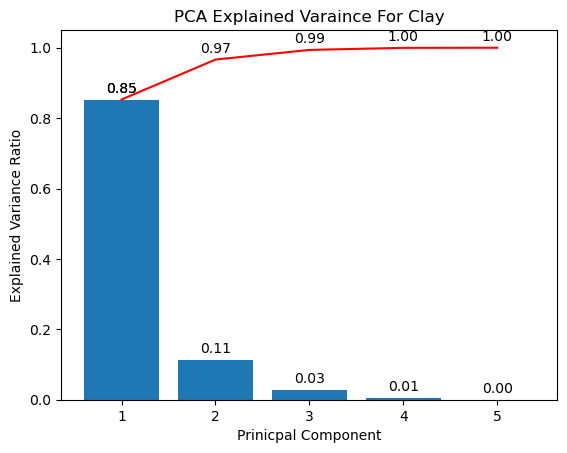

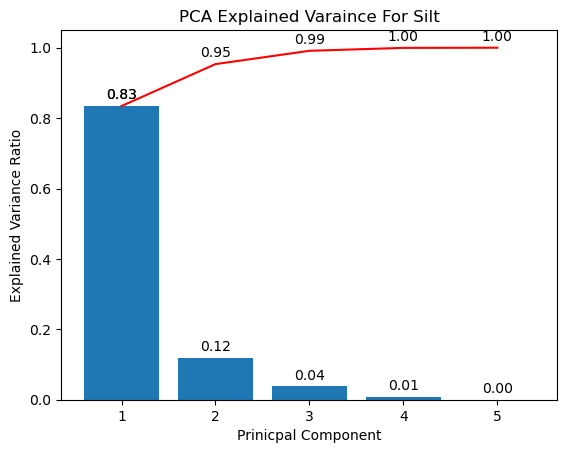

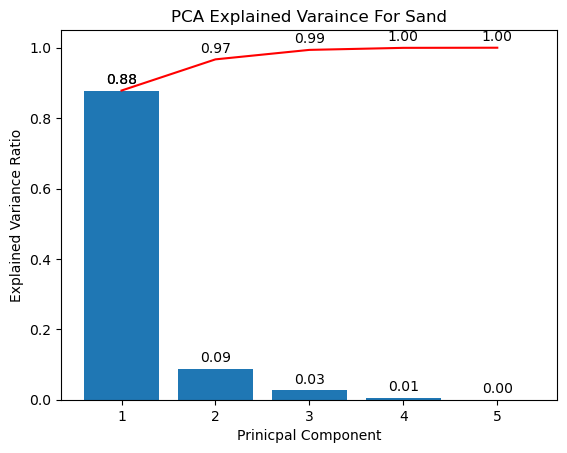

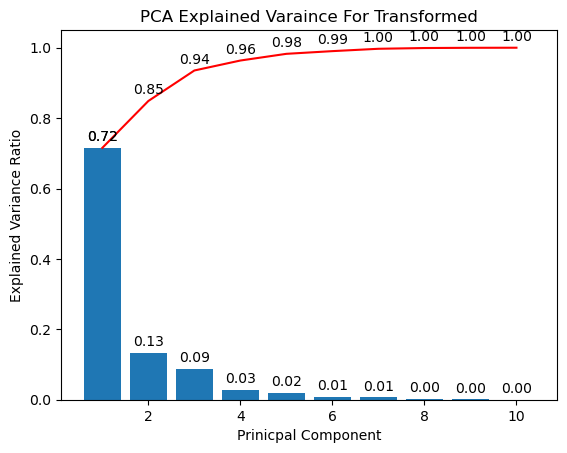

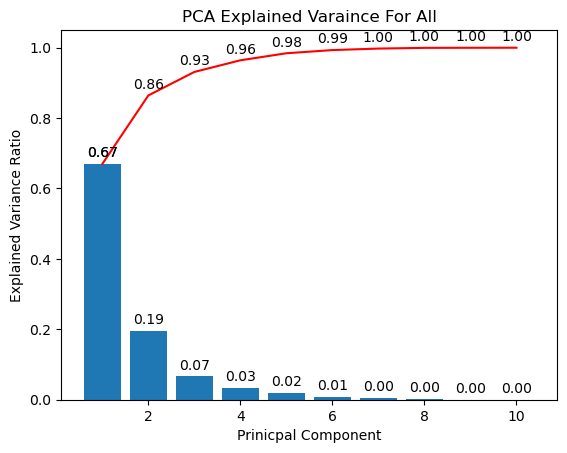

In [19]:
def plot_components(df_soil, name, cols):
    pca = PCA()
    pca.fit(df_soil[cols]) 
    explained_var = pca.explained_variance_ratio_
    if len(explained_var) > 10:
        explained_var = explained_var[:10]
    cum_var_exp = np.cumsum(explained_var)
    
    components = list(range(1, len(explained_var) + 1))
    plt.bar(components, explained_var)
    plt.plot(components, cum_var_exp, color = "red")
    
    for i in range(len(explained_var)):
        plt.annotate(
            "{:.2f}".format(explained_var[i]),
            (components[i], explained_var[i]),
            textcoords = "offset points",
            xytext = (0, 5),
            ha = "center"
        )
        plt.annotate(
            "{:.2f}".format(cum_var_exp[i]),
            (components[i], cum_var_exp[i]),
            textcoords = "offset points",
            xytext = (0, 5),
            ha = "center"
        )
    
    plt.title("PCA Explained Varaince For {}".format(name))
    plt.xlabel("Prinicpal Component")
    plt.ylabel("Explained Variance Ratio")
    # if len(explained_var) > 10:
    #     plt.xlim(0, 11)
    
    plt.show()

soil_all_cols = []
for name, cols in soil_col_sets.items():
    plot_components(soil, name, cols)
    soil_all_cols += cols

plot_components(soil, "All", soil_all_cols)

In [20]:
n_components = 4

df_soil = pd.DataFrame({
    "Lat": soil["Lat"],
    "Long": soil["Long"]
})
pca = PCA(n_components)
components = pca.fit_transform(soil[soil_all_cols])
for i in range(components.shape[1]):
    df_soil["Soil_{}".format(i + 1)] = components[:,i]

display(df_soil.describe())
df_soil

,Lat,Long,Soil_1,Soil_2,Soil_3,Soil_4
count,3597.000000,3597.000000,3.597000e+03,3.597000e+03,3.597000e+03,3.597000e+03
mean,5.094969,-74.535983,-4.045570e-15,1.011392e-15,1.517089e-15,6.321203e-17
std,3.238751,2.245669,5.998326e+01,3.233103e+01,1.892297e+01,1.332294e+01
min,-4.157500,-78.930311,-1.290364e+02,-1.165852e+02,-8.331546e+01,-5.749335e+01
25%,3.070182,-76.261740,-4.815872e+01,-2.047103e+01,-1.119605e+01,-7.743472e+00
50%,4.829722,-75.069444,-4.581881e+00,-1.583900e+00,-4.366431e-01,-3.250471e-01
75%,7.539351,-73.150560,4.541438e+01,1.958394e+01,1.031584e+01,6.914828e+00
max,12.365633,-67.490242,1.575212e+02,1.221986e+02,9.438138e+01,8.146414e+01


,Lat,Long,Soil_1,Soil_2,Soil_3,Soil_4
0,-0.570000,-72.470001,131.355106,-26.337923,1.693723,0.520589
1,-0.580000,-72.379997,-34.192109,3.771326,-22.767768,-18.567990
2,-1.280000,-70.830002,27.750900,-17.926913,-17.156457,-3.581450
3,1.262778,-77.289722,-29.544812,4.830663,1.809609,1.127096
4,1.116111,-77.427500,9.587123,-7.442354,-7.308818,-20.256515
...,...,...,...,...,...,...
3592,5.472748,-68.662856,85.202739,25.219087,8.354257,-7.498908
3593,5.554294,-68.486588,-46.708933,59.062595,-35.109342,-39.855524
3594,5.574345,-68.560311,56.289490,34.731958,22.827602,-19.162887
3595,4.466251,-67.876136,128.072972,-13.944550,-4.238957,6.650766


In [21]:
coords_rainfall = df_rainfall[["Lat", "Long"]].drop_duplicates()
coords_soil = df_soil[["Lat", "Long"]].drop_duplicates()

distances = distance_matrix(coords_rainfall, coords_soil)

coords_soil["Closest"] = np.argmin(distances, axis = 0)
coords_rainfall.reset_index(inplace = True, names = "Closest")
coords_soil = pd.merge(coords_soil, coords_rainfall, on = "Closest")

coords_soil

,Lat_x,Long_x,Closest,Lat_y,Long_y
0,-0.570000,-72.470001,6,-1.007618,-72.141613
1,-0.580000,-72.379997,6,-1.007618,-72.141613
2,-0.400000,-72.150000,6,-1.007618,-72.141613
3,-0.466667,-72.216667,6,-1.007618,-72.141613
4,-0.466667,-72.233333,6,-1.007618,-72.141613
...,...,...,...,...,...
3590,5.106861,-70.543333,449,5.135381,-70.864961
3591,4.899972,-71.007889,449,5.135381,-70.864961
3592,4.911889,-70.996389,449,5.135381,-70.864961
3593,5.106333,-70.829389,449,5.135381,-70.864961


In [22]:
df_soil2 = (
    pd.merge(
        df_soil,
        coords_soil,
        left_on = ["Lat", "Long"],
        right_on = ["Lat_x", "Long_x"]
    )
    .drop(["Lat", "Long", "Lat_x", "Long_x", "Closest"], axis = 1)
    .rename({
        "Lat_y": "Lat",
        "Long_y": "Long"
    }, axis = 1)
    .groupby(["Lat", "Long"])
    .mean()
    .reset_index()
    .merge(
        coords_rainfall.drop("Closest", axis = 1),
        how = "outer",
        on = ["Lat", "Long"]
    )
)

display(df_soil2.info())
display(df_soil2.describe())
df_soil2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Lat     1063 non-null   float64
 1   Long    1063 non-null   float64
 2   Soil_1  752 non-null    float64
 3   Soil_2  752 non-null    float64
 4   Soil_3  752 non-null    float64
 5   Soil_4  752 non-null    float64
dtypes: float64(6)
memory usage: 50.0 KB


None

,Lat,Long,Soil_1,Soil_2,Soil_3,Soil_4
count,1063.000000,1063.000000,752.000000,752.000000,752.000000,752.000000
mean,5.545912,-74.628873,4.972265,-1.196997,-0.063340,0.272923
std,2.573251,1.705331,44.462816,20.823144,13.948217,9.923186
min,-4.203165,-81.718525,-117.119598,-67.465938,-70.114099,-44.388061
25%,4.214098,-75.763132,-26.784823,-14.801274,-7.781517,-4.990665
50%,5.500707,-74.753281,3.771753,-1.940775,-0.224017,-0.205305
75%,6.846930,-73.415627,34.948253,12.650425,7.704736,5.031473
max,13.381425,-67.046459,157.521167,79.730275,49.764472,74.514142


,Lat,Long,Soil_1,Soil_2,Soil_3,Soil_4
0,-4.203165,-69.935907,2.921596,-0.724146,-3.821540,-5.245456
1,-3.788867,-70.355642,-58.737516,-6.039631,-6.917372,-11.271080
2,-2.458989,-69.859741,-29.970689,14.766859,-4.180391,-4.802231
3,-1.747145,-73.209101,3.835822,-22.014811,-11.914056,-5.726359
4,-1.378972,-72.804280,-2.655820,5.312632,-7.289223,-5.174381
...,...,...,...,...,...,...
1058,10.777471,-74.853162,NaN,NaN,NaN,NaN
1059,10.917119,-74.799151,NaN,NaN,NaN,NaN
1060,12.556732,-81.718525,NaN,NaN,NaN,NaN
1061,12.576855,-81.705052,NaN,NaN,NaN,NaN


In [23]:
imputer = KNNImputer(n_neighbors = 3)
cols = list(df_soil2.columns)
df_soil2[cols] = imputer.fit_transform(df_soil2[cols])

display(df_soil2.info())
display(df_soil2.describe())
df_soil2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Lat     1063 non-null   float64
 1   Long    1063 non-null   float64
 2   Soil_1  1063 non-null   float64
 3   Soil_2  1063 non-null   float64
 4   Soil_3  1063 non-null   float64
 5   Soil_4  1063 non-null   float64
dtypes: float64(6)
memory usage: 50.0 KB


None

,Lat,Long,Soil_1,Soil_2,Soil_3,Soil_4
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,5.545912,-74.628873,4.520046,-0.708175,0.494710,0.200540
std,2.573251,1.705331,41.865439,19.134821,12.693717,9.116855
min,-4.203165,-81.718525,-117.119598,-67.465938,-70.114099,-44.388061
25%,4.214098,-75.763132,-25.935272,-12.870773,-6.148036,-4.769329
50%,5.500707,-74.753281,4.574126,-0.956848,0.702325,-0.056797
75%,6.846930,-73.415627,32.600366,11.384616,7.545464,4.694865
max,13.381425,-67.046459,157.521167,79.730275,49.764472,74.514142


,Lat,Long,Soil_1,Soil_2,Soil_3,Soil_4
0,-4.203165,-69.935907,2.921596,-0.724146,-3.821540,-5.245456
1,-3.788867,-70.355642,-58.737516,-6.039631,-6.917372,-11.271080
2,-2.458989,-69.859741,-29.970689,14.766859,-4.180391,-4.802231
3,-1.747145,-73.209101,3.835822,-22.014811,-11.914056,-5.726359
4,-1.378972,-72.804280,-2.655820,5.312632,-7.289223,-5.174381
...,...,...,...,...,...,...
1058,10.777471,-74.853162,10.975287,6.908677,0.144670,4.245071
1059,10.917119,-74.799151,18.306853,-30.313603,3.260610,3.525676
1060,12.556732,-81.718525,3.731165,-7.619608,3.737395,1.358470
1061,12.576855,-81.705052,3.731165,-7.619608,3.737395,1.358470


# Merge All Datasets

In [24]:
df_rainfall["Date"] = pd.to_datetime(df_rainfall["Date"], format = "%Y-%m-%d")
df_rainfall["Year"] = df_rainfall["Date"].dt.year
df_rainfall = df_rainfall[df_rainfall["Year"] < 2018]

df = pd.merge(df_rainfall, df_forest, how = "inner", on = ["Lat", "Long", "Year"])
df = pd.merge(df, df_landslides, "outer", ["Department", "Municipality", "Date"])
df = pd.merge(df, df_soil2, how = "outer", on = ["Lat", "Long"])
df["Landslide"] = df["Landslide"].fillna(0).astype(int)

display(df.info())
display(df.describe())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112010 entries, 0 to 3112009
Data columns (total 15 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   Date                     datetime64[ns]
 1   Lat                      float64       
 2   Long                     float64       
 3   Total Rainfall Today     float64       
 4   Rainfall Duration Today  int64         
 5   Year                     int32         
 6   Department               object        
 7   Municipality             object        
 8   elevation                float64       
 9   Forest Loss %            float64       
 10  Landslide                int64         
 11  Soil_1                   float64       
 12  Soil_2                   float64       
 13  Soil_3                   float64       
 14  Soil_4                   float64       
dtypes: datetime64[ns](1), float64(9), int32(1), int64(2), object(2)
memory usage: 344.3+ MB


None

,Date,Lat,Long,Total Rainfall Today,Rainfall Duration Today,Year,elevation,Forest Loss %,Landslide,Soil_1,Soil_2,Soil_3,Soil_4
count,3112010,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06
mean,2013-12-31 11:56:44.517851648,5.550238e+00,-7.463048e+01,6.184781e+00,1.052745e+01,2.013500e+03,1.189075e+03,1.453406e-02,1.200832e-03,4.548845e+00,-7.190569e-01,4.887962e-01,1.950313e-01
min,2010-01-01 00:00:00,-4.203165e+00,-8.171853e+01,0.000000e+00,0.000000e+00,2.010000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-1.171196e+02,-6.746594e+01,-7.011410e+01,-4.438806e+01
25%,2012-01-01 00:00:00,4.216550e+00,-7.576187e+01,4.000000e-01,2.000000e+00,2.012000e+03,2.238231e+02,3.606079e-03,0.000000e+00,-2.593527e+01,-1.283423e+01,-6.150866e+00,-4.736427e+00
50%,2013-12-31 00:00:00,5.503838e+00,-7.475520e+01,2.800000e+00,1.000000e+01,2.013000e+03,1.191456e+03,8.837461e-03,0.000000e+00,4.619639e+00,-9.568478e-01,7.023253e-01,-5.830288e-02
75%,2016-01-01 00:00:00,6.854309e+00,-7.341802e+01,8.200000e+00,1.700000e+01,2.016000e+03,1.909895e+03,1.889565e-02,0.000000e+00,3.257890e+01,1.138163e+01,7.557220e+00,4.684273e+00
max,2017-12-31 00:00:00,1.338142e+01,-6.704646e+01,3.723000e+02,2.400000e+01,2.017000e+03,3.670899e+03,1.590021e-01,1.000000e+00,1.575212e+02,7.973027e+01,4.976447e+01,7.451414e+01
std,NaN,2.571905e+00,1.703340e+00,9.952174e+00,8.497873e+00,2.291145e+00,9.327786e+02,1.695834e-02,3.463221e-02,4.181527e+01,1.911098e+01,1.268671e+01,9.104870e+00


,Date,Lat,Long,Total Rainfall Today,Rainfall Duration Today,Year,Department,Municipality,elevation,Forest Loss %,Landslide,Soil_1,Soil_2,Soil_3,Soil_4
0,2010-01-01,-4.203165,-69.935907,0.4,4,2010,Amazonas,Leticia,78.378479,0.000479,0,2.921596,-0.724146,-3.821540,-5.245456
1,2010-01-02,-4.203165,-69.935907,0.0,0,2010,Amazonas,Leticia,78.378479,0.000479,0,2.921596,-0.724146,-3.821540,-5.245456
2,2010-01-03,-4.203165,-69.935907,1.6,11,2010,Amazonas,Leticia,78.378479,0.000479,0,2.921596,-0.724146,-3.821540,-5.245456
3,2010-01-04,-4.203165,-69.935907,6.7,17,2010,Amazonas,Leticia,78.378479,0.000479,0,2.921596,-0.724146,-3.821540,-5.245456
4,2010-01-05,-4.203165,-69.935907,24.9,24,2010,Amazonas,Leticia,78.378479,0.000479,0,2.921596,-0.724146,-3.821540,-5.245456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112005,2017-12-27,13.381425,-81.365743,1.6,13,2017,San Andrés y Providencia,Providencia,22.483635,0.000564,0,-39.715622,8.102553,-3.819353,1.564076
3112006,2017-12-28,13.381425,-81.365743,6.2,23,2017,San Andrés y Providencia,Providencia,22.483635,0.000564,0,-39.715622,8.102553,-3.819353,1.564076
3112007,2017-12-29,13.381425,-81.365743,9.9,23,2017,San Andrés y Providencia,Providencia,22.483635,0.000564,0,-39.715622,8.102553,-3.819353,1.564076
3112008,2017-12-30,13.381425,-81.365743,2.6,17,2017,San Andrés y Providencia,Providencia,22.483635,0.000564,0,-39.715622,8.102553,-3.819353,1.564076


In [25]:
df.to_csv("../datasets/full_dataset.csv", index = False)